In [130]:
import csv 
import numpy as np
import matplotlib.pyplot as plt;

#########################
def normalization_data (X,dim):
    m = np.mean (X,axis=0);
    s = np.std (X,axis=0);
    return (X-m.reshape (1,dim)) / s.reshape(1,dim);

#########################


# データ取得

# 教師データ
train_file = open("./data/vowel_training.csv", "r", encoding="utf_8", errors="", newline="" )
train_f = csv.reader(train_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
header = next(train_f);
train_data = np.array ([[float (x) for x in row[1:]] for row in train_f]);
train_Y = np.array ([int(x-1) for x in train_data[:,0]]);
train_X_raw = train_data[:,1:];

# テストデータ
test_file = open("./data/vowel_test.csv", "r", encoding="utf_8", errors="", newline="" )
test_f = csv.reader(test_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
header = next(test_f);
test_data = np.array ([[float (x) for x in row[1:]] for row in test_f]);
test_Y = np.array ([int(x-1) for x in test_data[:,0]]);
test_X_raw = test_data[:,1:];


K = len(np.unique(train_Y));
N, dim = train_X_raw.shape;
N_test,_ = test_X_raw.shape;

# データを正規化
train_X = normalization_data (train_X_raw, dim)
test_X = normalization_data (test_X_raw, dim)



pi = np.zeros ((K,1));
Sigma = np.zeros ((K, dim,dim));
mu = np.zeros ((K, dim));

for i in range (N):
    k = train_Y [i];
    pi[k,0] += 1;
    mu[k,:] += train_X [i,:]

mu = mu / pi;

for i in range (N):
    k = train_Y [i];
    xi = (train_X[i,:]-mu[k,:]).reshape (dim,1);
    
    Sigma[k,:,:] += xi.dot (xi.T);
    


Sigma_all = np.sum (Sigma, axis=0) / (N-K);

for k in range (K):
    Sigma[k,:,:] = Sigma[k,:,:] / (pi[k,0]-1);


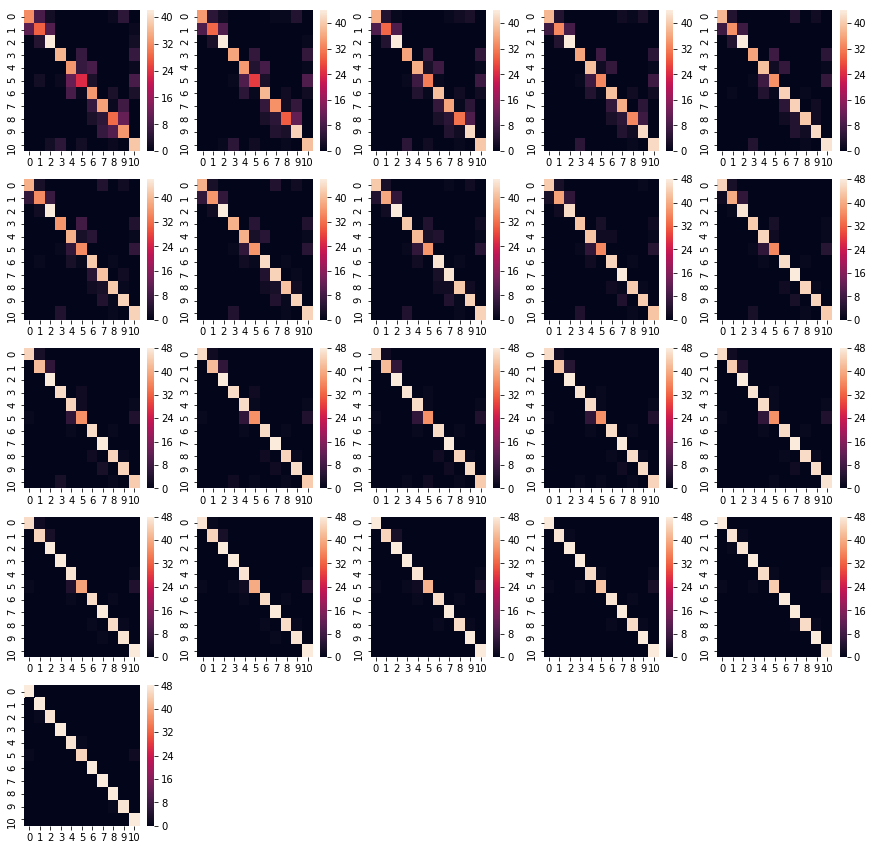

In [131]:
# 教師データに対する誤分類率の計算
# 混同行列の表示

import seaborn as sns;

fig = plt.figure (figsize=(15,15))

dalpha = 0.05;
alphas = np.arange (0,1+dalpha,dalpha);

count_train = np.zeros_like (alphas);
idx = 0;
for alpha in alphas:
    confusion_matrix = np.zeros ((K,K));
    Sigma_hat = np.zeros_like (Sigma);
    for k in range (K):
        Sigma_hat[k,:,:] = alpha * Sigma[k,:,:] + (1-alpha) * Sigma_all;
    
    
    
    W, _ = np.linalg.eig (Sigma_hat);
   
    delta_c = -0.5* np.sum (np.log(W), axis=1) + pi/N;
    
    counter = 0.0;
    for i in range (N):
        delta = np.zeros ((1,K),dtype=float);
        for k in range (K):
            x_ik = (train_X[i,:]-mu[k,:]).reshape (dim,1);
            delta[0,k] = delta_c [0,k] - 0.5 * x_ik.T.dot (np.linalg.inv (Sigma_hat[k,:,:])).dot (x_ik);
        
        k_pred = np.argmax (delta[0,:]);
        confusion_matrix[train_Y[i],k_pred] += 1;
        if train_Y[i] != k_pred:
            counter+=1.0;
   
    count_train[idx] = counter / N;
    idx += 1;
   
    ax = fig.add_subplot (5,5,idx);
    sns.heatmap (confusion_matrix)

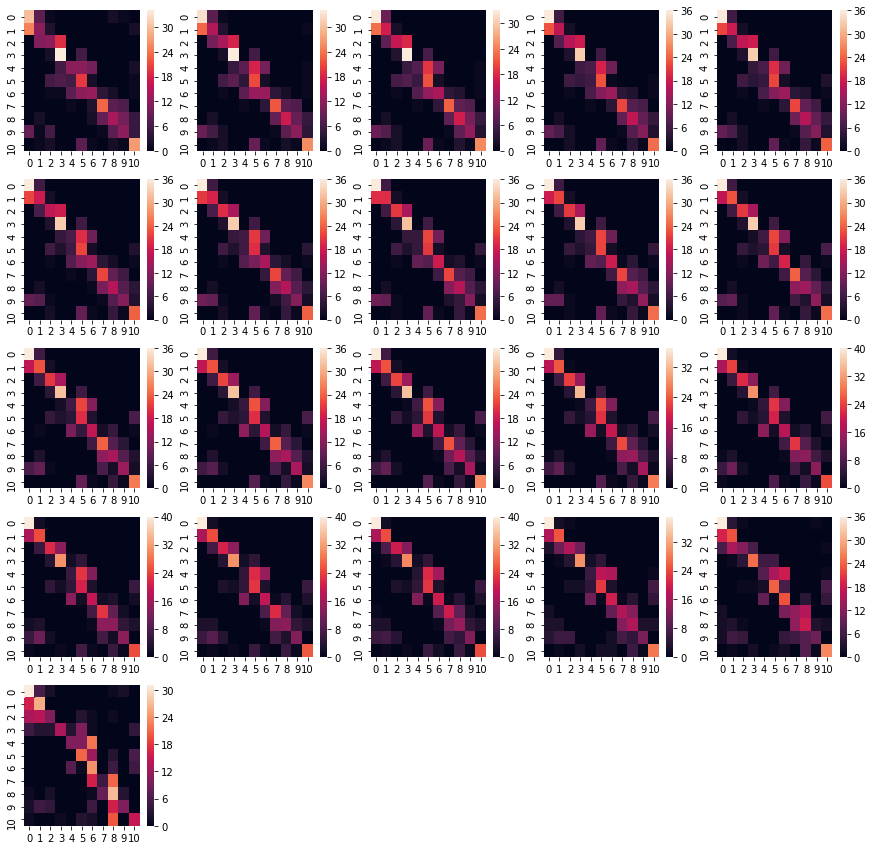

In [133]:
# テストデータに対する誤分類率の計算
# 混同行列の表示

fig = plt.figure (figsize=(15,15))

count_test = np.zeros_like (alphas);
idx = 0;
for alpha in alphas:
    confusion_matrix = np.zeros ((K,K));
    Sigma_hat = np.zeros_like (Sigma);
    for k in range (K):
        Sigma_hat[k,:,:] = alpha * Sigma[k,:,:] + (1-alpha) * Sigma_all;
    
    
    
    W, _ = np.linalg.eig (Sigma_hat);
   
    delta_c = -0.5* np.sum (np.log(W), axis=1) + pi/N;
    
    counter = 0.0;
    for i in range (N_test):
        delta = np.zeros ((1,K),dtype=float);
        for k in range (K):
            x_ik = (test_X[i,:]-mu[k,:]).reshape (dim,1);
            delta[0,k] = delta_c [0,k] - 0.5 * x_ik.T.dot (np.linalg.inv (Sigma_hat[k,:,:])).dot (x_ik);
        
        k_pred = np.argmax (delta[0,:]);
        confusion_matrix[test_Y[i],k_pred] += 1;
        if test_Y[i] != k_pred:
            counter+=1.0;
   
    count_test[idx] = counter / N;
    idx += 1;
   
    ax = fig.add_subplot (5,5,idx);
    sns.heatmap (confusion_matrix)

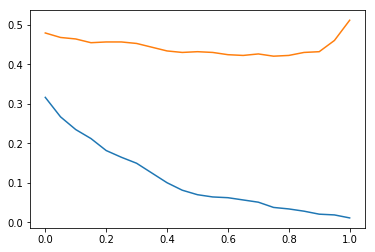

In [134]:
# 誤分類率の比較

plt.figure ();
plt.plot (alphas, count_train);
plt.plot (alphas, count_test)